## Imports

The following libraries are used in the problem implementation:


In [1]:
import numpy as np
from math import factorial, exp
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

## Poisson probability mass function

We assume that the number of cars requested and returned at each location follows a Poisson distribution. Specifically, the probability of observing n cars is given by:

$$P(N = n | \lambda) = \frac{\lambda^n e^{-\lambda}}{n!}$$

where:

- $\lambda$ is the rate parameter (expected number of events)


In [2]:
def poisson(n, lam):
    """
    Compute the Poisson probability P(N = n) for a given rate λ.

    Parameters
    ----------
    n : int
        The number of events (e.g., number of rental requests or returns).
    lam : float
        The Poisson rate parameter λ (expected number of events).

    Returns
    -------
    float
        The value of the Poisson PMF: (λ^n * e^{-λ}) / n!
    """
    return (lam**n) * exp(-lam) / factorial(n)

## Constants

The following constants are used in the implementation:


In [3]:
# Maximum number of cars at each location
MAX_CARS = 20

# Max number of cars allowed to be moved overnight
MAX_MOVE = 5

# Discount factor
GAMMA = 0.9

# Convergence threshold
THETA = 1e-1

# Upper bound for Poisson summation truncation.
# Values above n=10 contribute negligibly for common λ values (2–4 range).
POISSON_UPPER = 11

## Poisson distribution parameters

We suppose that $\\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns:


In [4]:
# Expected number of rental requests at each location
request_lam = [3, 4]

# Expected number of returns at each location
return_lam = [3, 2]

## Precompute Poisson probabilities

To speed up value iteration or simulations, we precompute and store the Poisson probabilities $P(N = n \mid \lambda)$ in a dictionary for fast lookup.

We truncate the distribution at `POISSON_UPPER - 1` to limit computation.

- Keys: Tuples of the form `(n, λ)`.
- Example: `poisson_cache[(4, 3)] = P(N=4 | λ=3)`.


In [5]:
poisson_cache = {}
for lam in request_lam + return_lam:
    for n in range(0, POISSON_UPPER):
        poisson_cache[(n, lam)] = poisson(n, lam)

## Helper Function to Visualize Policies

The following function visualize a given policy in a heatmap:


In [6]:
def visualize_policy(pi, title):
    """
    Plot a heatmap of the policy for Jack's Car Rental.

    Parameters
    ----------
    pi : 2D array
        Policy matrix where each entry gives the number of cars
        moved from location 1 to location 2 (negative = move back).
    title : str
        Title of the plot.

    Notes
    -----
    The heatmap shows how the recommended action changes for each
    combination of cars at the two locations.
    """

    plt.figure(figsize=(6, 6))
    plt.imshow(pi, cmap="coolwarm", origin="lower")
    plt.colorbar(label="Cars to be moved from the first location to second")
    plt.title(title)
    plt.xlabel("#Cars at second location")
    plt.ylabel("#Cars at first location")
    plt.show()

## Expected Return

The following function computes the expected return of taking an action given an state:

$$\sum_{s',, r} p(s', r \mid s, \pi(s)) \left[ r + \gamma V(s') \right]$$


In [7]:
def expected_return(s1, s2, action, V):
    """
    Estimate the expected return of taking a given action in state (s1, s2).

    This computes the value of:
        - moving cars overnight,
        - earning rental rewards,
        - receiving returned cars,
        - and the discounted value of the next state.

    Parameters
    ----------
    s1, s2 : int
        Number of cars at locations 1 and 2.
    action : int
        Cars moved from location 1 to 2 (negative means the opposite).
    V : 2D array
        Current state-value function.

    Returns
    -------
    float
        Expected return from taking the action in this state.
    """

    # Apply action (move cars between locations)
    cars1 = min(MAX_CARS, max(0, s1 - action))
    cars2 = min(MAX_CARS, max(0, s2 + action))

    # Cost of moving cars
    reward = -2 * abs(action)

    expected = 0.0

    # Loop over rental requests
    for req1 in range(POISSON_UPPER):
        for req2 in range(POISSON_UPPER):

            # Probability of this pair of requests
            p_req = (
                poisson_cache[(req1, request_lam[0])]
                * poisson_cache[(req2, request_lam[1])]
            )

            # Rentals that can actually be fulfilled
            rent1 = min(cars1, req1)
            rent2 = min(cars2, req2)

            # Earnings from rentals
            rental_reward = 10 * (rent1 + rent2)

            # Cars remaining after rentals
            c1_after = cars1 - rent1
            c2_after = cars2 - rent2

            # Loop over returned cars
            for ret1 in range(POISSON_UPPER):
                for ret2 in range(POISSON_UPPER):

                    # Probability of this pair of returns
                    p_ret = (
                        poisson_cache[(ret1, return_lam[0])]
                        * poisson_cache[(ret2, return_lam[1])]
                    )

                    # Update the number of cars after returns
                    new_c1 = min(MAX_CARS, c1_after + ret1)
                    new_c2 = min(MAX_CARS, c2_after + ret2)

                    # Probability of request and return pair
                    prob = p_req * p_ret

                    # Add to expected return
                    expected += prob * (rental_reward + GAMMA * V[new_c1, new_c2])

    return reward + expected

## Policy Iteration

The following code evaluates and improves the policy.
Visualizations are shown to help understand the algorithm behaviour:


Initial Policy


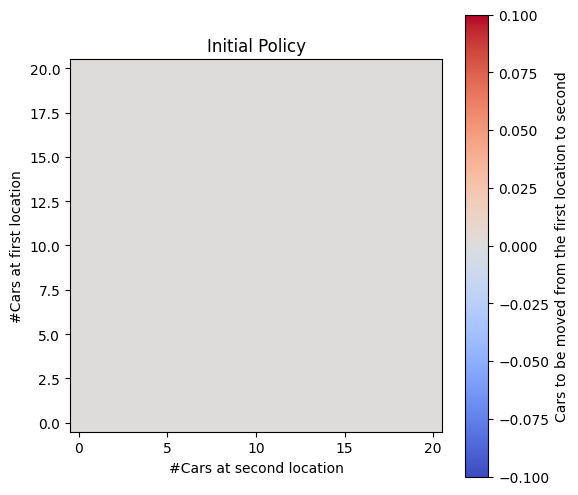

Policy Iteration 1
Improving Policy : 100%|██████████| 441/441 [00:18<00:00, 23.42it/s]


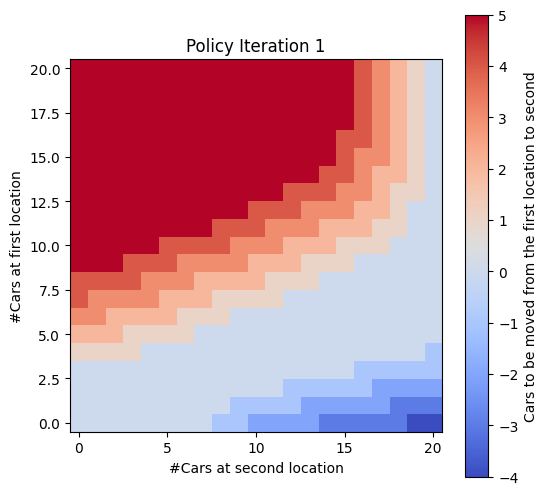

Policy Iteration 2
Improving Policy : 100%|██████████| 441/441 [00:18<00:00, 23.26it/s]


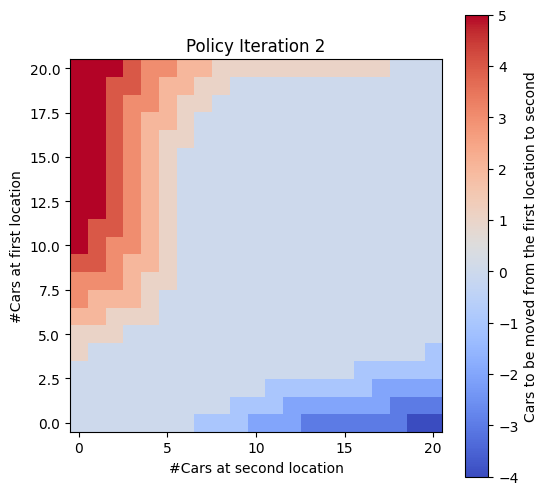

Policy Iteration 3
Improving Policy : 100%|██████████| 441/441 [00:19<00:00, 22.96it/s]


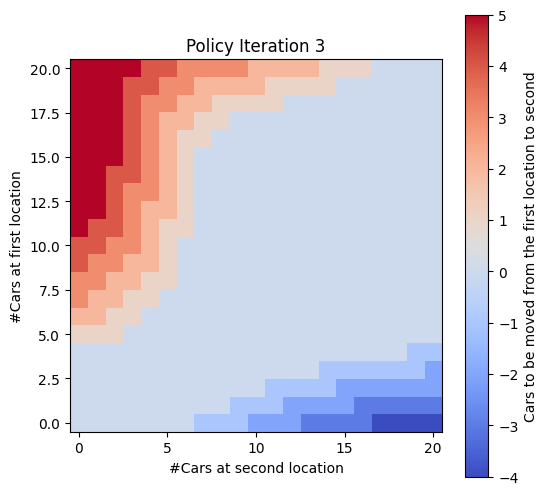

Policy Iteration 4
Improving Policy : 100%|██████████| 441/441 [00:19<00:00, 23.10it/s]


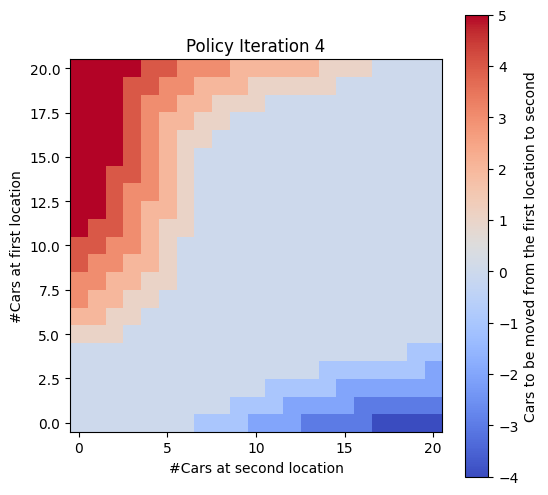

Policy Iteration 5
Improving Policy : 100%|██████████| 441/441 [00:19<00:00, 23.17it/s]


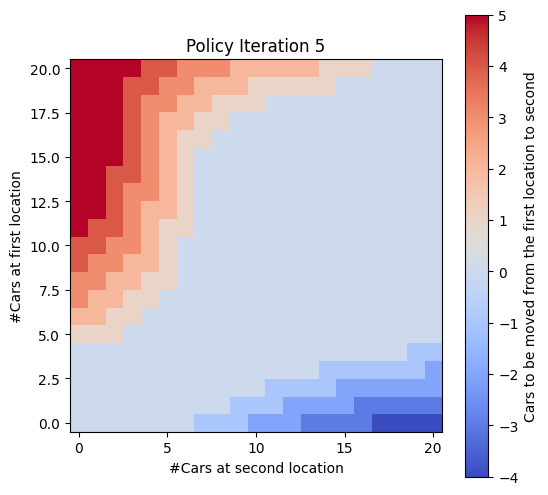

Policy iteration complete.


In [8]:
# Value function V[s1, s2]
V = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

# Policy π[s1, s2]
pi = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

# Visualize initial policy
print(f"Initial Policy")
visualize_policy(pi, title=f"Initial Policy")


# ---------- POLICY ITERATION ----------
iteration = 0
while True:
    iteration += 1
    print(f"Policy Iteration {iteration}")

    # ----- POLICY EVALUATION -----
    while True:

        # Reset delta
        delta = 0

        # Iterate over states to evaluate policy
        with tqdm(total=(MAX_CARS + 1) ** 2, desc="Evaluating Policy", file=sys.stdout) as pbar:
            for s1 in range(MAX_CARS + 1):
                for s2 in range(MAX_CARS + 1):

                    # Update progress bar
                    pbar.update(1)

                    # Update value functions
                    v = V[s1, s2]
                    a = pi[s1, s2]
                    V[s1, s2] = expected_return(s1, s2, a, V)
                    delta = max(delta, abs(v - V[s1, s2]))

        # Break if converged
        if delta < THETA:
            break

    # ----- POLICY IMPROVEMENT -----
    policy_stable = True

    # Iterate over states to improve the policy
    with tqdm(total=(MAX_CARS + 1) ** 2, desc="Improving Policy ", file=sys.stdout) as pbar:
        for s1 in range(MAX_CARS + 1):
            for s2 in range(MAX_CARS + 1):

                # Update progress bar
                pbar.update(1)

                # Record current action
                old_action = pi[s1, s2]

                # Actions available: −min(s2,5) … +min(s1,5)
                actions = range(-min(s2, MAX_MOVE), min(s1, MAX_MOVE) + 1)

                # Choose best action
                returns = []
                for a in actions:
                    returns.append(expected_return(s1, s2, a, V))
                best_action = list(actions)[np.argmax(returns)]

                # Update policy if needed
                pi[s1, s2] = best_action

                # If policy changed, mark as unstable
                if best_action != old_action:
                    policy_stable = False

    # Visualize the policy after this iteration
    visualize_policy(pi, title=f"Policy Iteration {iteration}")

    # Break if policy is stable
    if policy_stable:
        break

print("Policy iteration complete.")